In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns


import statsmodels.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2,Analyses.paper_stats as ps
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()
#info.update_paths()

In [3]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=tmf.TreeMazeZones().zones2, ordered=True)

In [32]:
fig_path = ei.Path('/home/alexgonzalez/Documents/treemazefigs/encoder_decoder/')

## zone decoder

In [41]:
t = info.get_zone_neural_decoder()

In [42]:

unit_groups = [f'g{i}' for i in range(3)]
t['n_units_cat'] = pd.qcut(t.n_units,3, labels=[f'g{i}' for i in range(3)])

In [43]:
tc = t[(t.trial_type=='out') & (t.feature_add.isin(['None','cue']))].groupby(['session','zones','n_units_cat', 'feature_add'], observed=True).mean().reset_index()
tc['dist']/=10

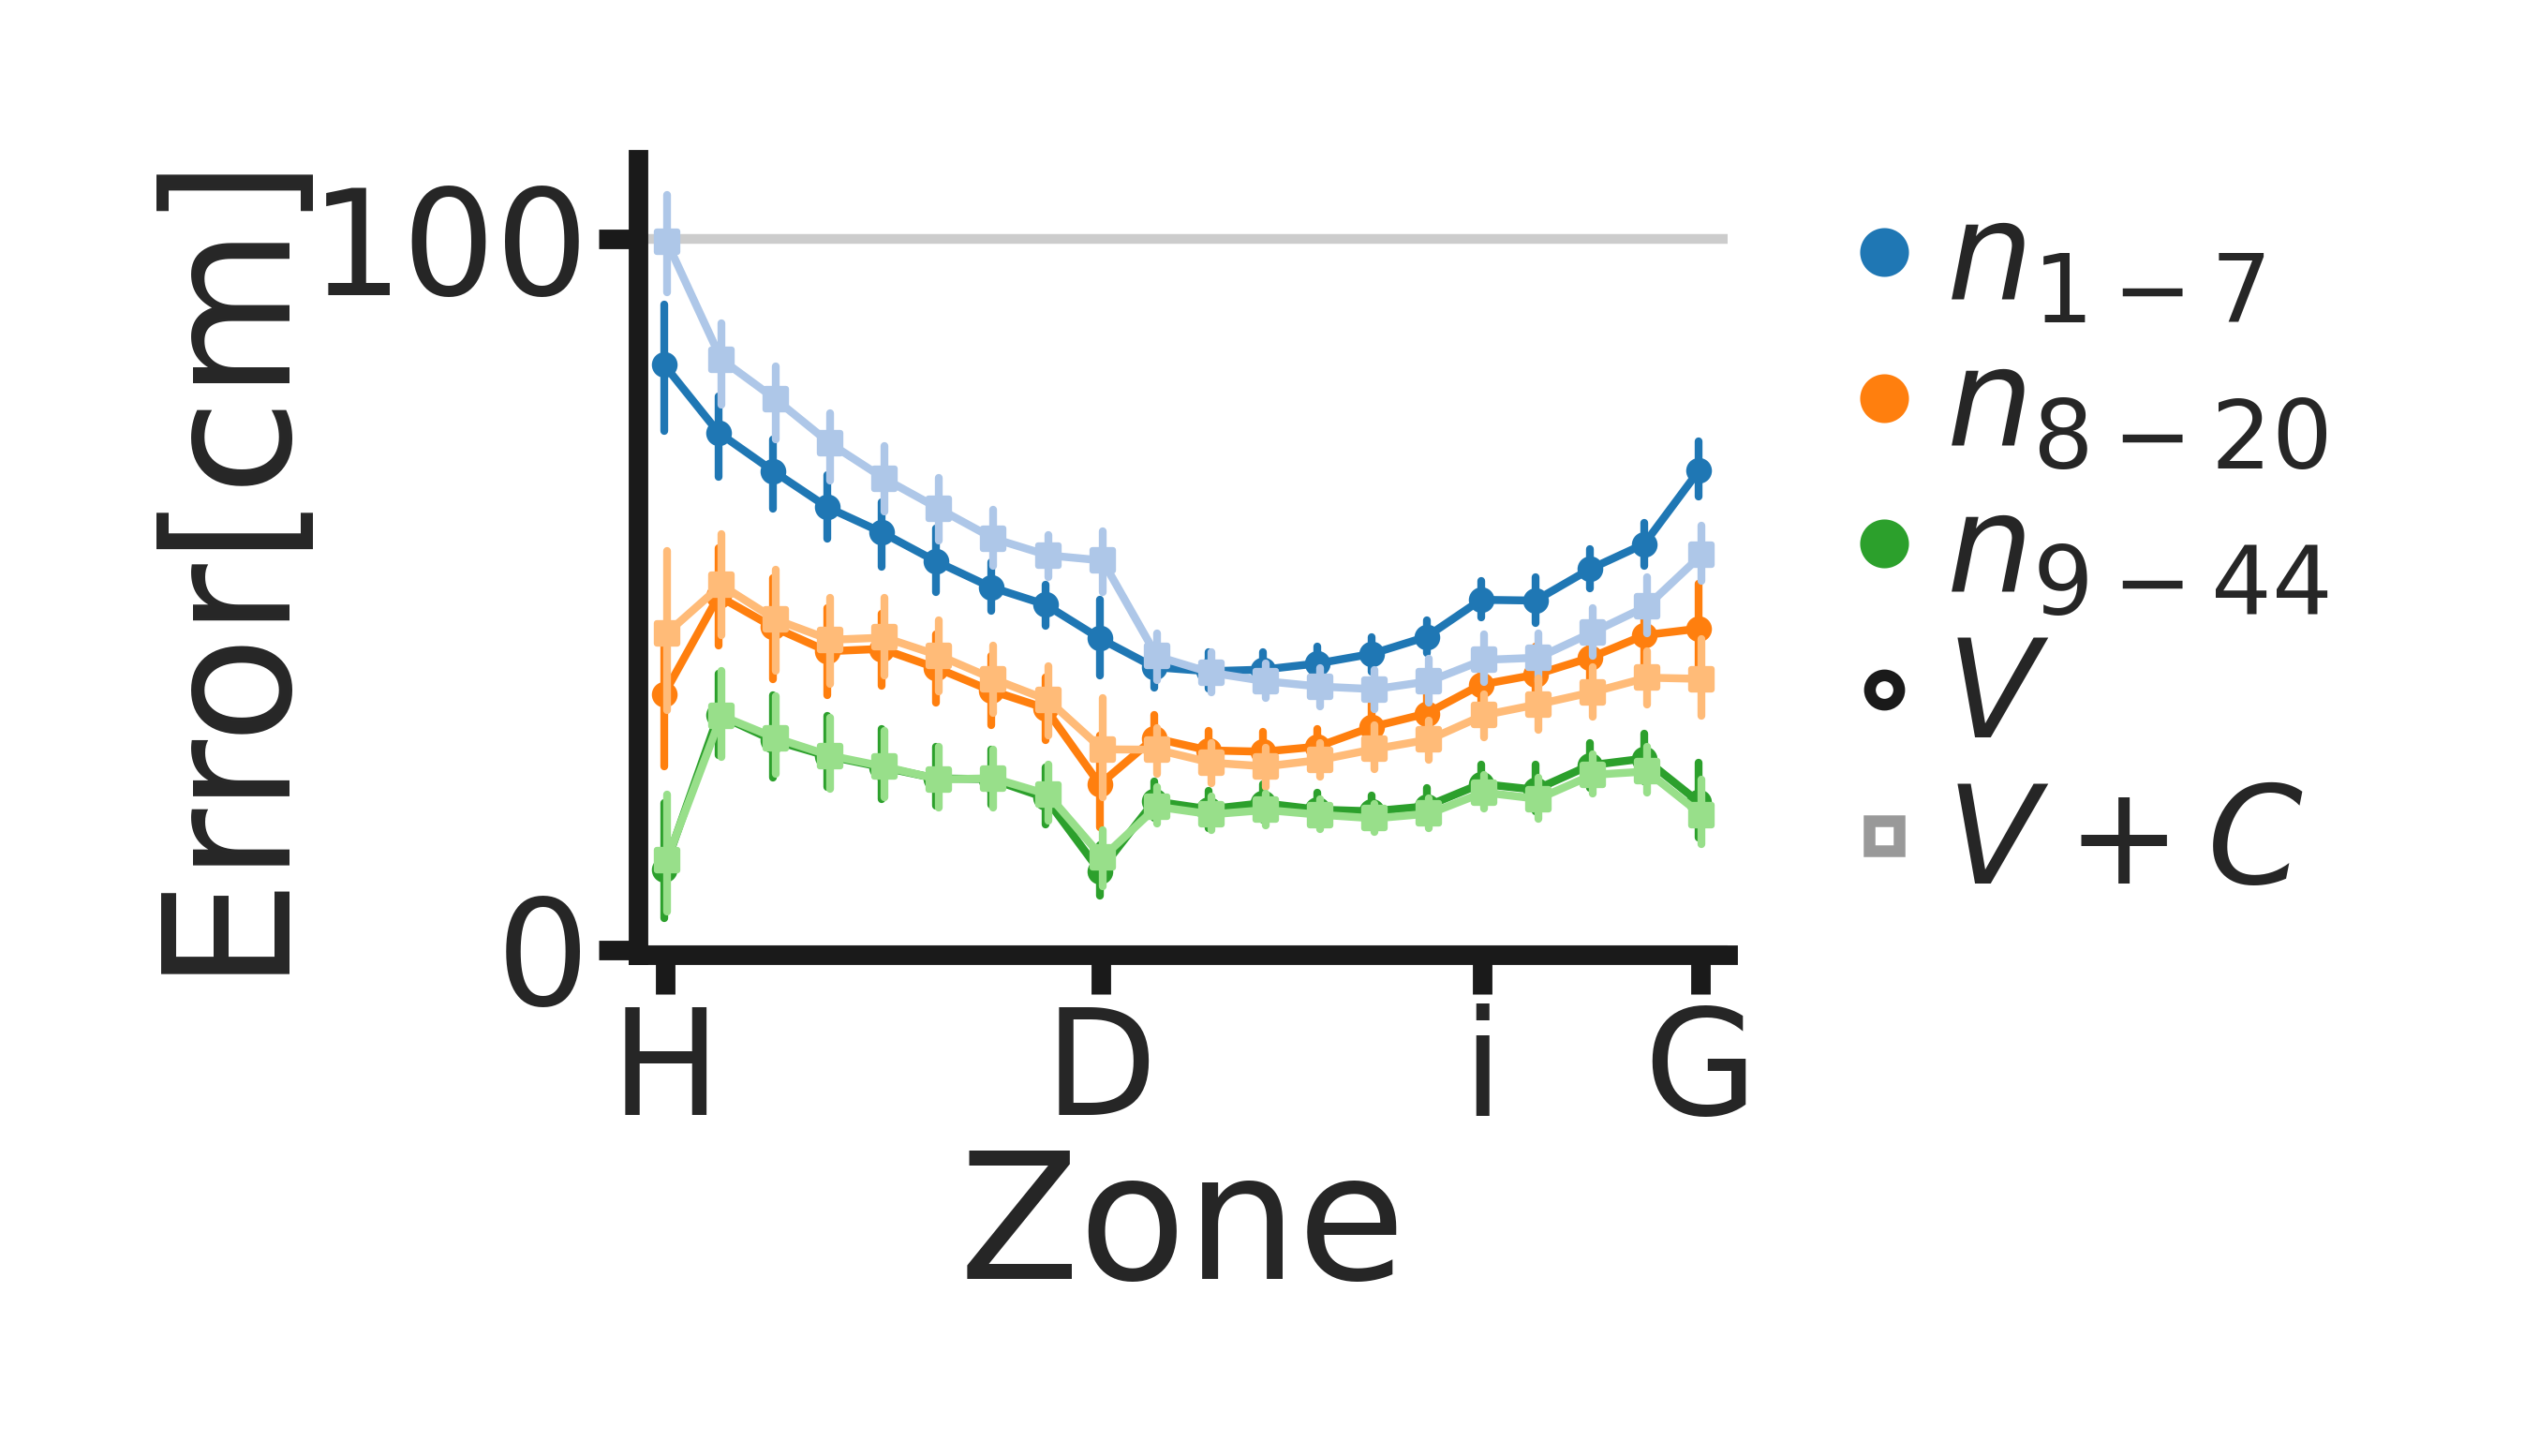

In [155]:
dpi=1500
f, ax = plt.subplots(figsize=(1,0.75), dpi=dpi)
cols = sns.color_palette('tab20', n_colors=6)
params = dict(leg_marker_size=1.5, markers=["o",'s'], leg_pos=[1,-0.1], 
              tick_fontsize=7.5, fontsize=9, legend_fontsize=7,
              point_scale=0.15, errwidth=0.4, ci=95, ylabel='Error[cm]',
              )

pf.setup_axes(ax, fontsize=params['tick_fontsize'])

cnt=0
for g in unit_groups:
    sns.pointplot(data=tc[tc.n_units_cat==g],x='zones', y='dist', hue='feature_add', 
                  palette=cols[cnt:cnt+2], markers=params['markers'],
                  scale=params['point_scale'], errwidth=params['errwidth'], ci=params['ci'],
                  dodge=True, legend=False,
                  ax=ax)
    cnt+=2

ax.set_xticks([0, 8, 15, 19])

ax.set_xlabel('Zone', fontsize=params['fontsize'], labelpad=0)
ax.set_ylabel(params['ylabel'], fontsize=params['fontsize'], labelpad=0)

hue_labels=[f'$n_{{1-7}}$', f'$n_{{8-20}}$',f'$n_{{9-44}}$']
model_labels = [r'$V$',r'$V+C$' ]
model_sat = ['0.1', '0.6' ]

legend_elements = []
for ii, k in enumerate(hue_labels):
    legend_elements.append(
        mpl.lines.Line2D([0], [0], marker='o', color=cols[ii*2], lw=0, label=k, markerfacecolor=cols[ii*2],markersize=params['leg_marker_size']))
    
for ii, k in enumerate(model_labels):
    legend_elements.append(
        mpl.lines.Line2D([0], [0], marker=params['markers'][ii], color=model_sat[ii], lw=0, label=k, markerfacecolor='None', mec=model_sat[ii], markersize=params['leg_marker_size'], markeredgewidth=0.6))
    


ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=params['leg_pos'], frameon=False,
          fontsize=params['legend_fontsize'], labelspacing=0.1, handlelength=0.5, handletextpad=0.2)


fn = f"zone_decoder_dist_x_zone_unit.svg"
f.savefig(fig_path/fn, format='svg', dpi=dpi, facecolor=None, pad_inches=0, bbox_inches='tight')

In [51]:
tc = t[(t.trial_type=='out') & (t.feature_add.isin(['None','cue']))].groupby(['session','subject','zones','n_units_cat', 'feature_add', 'fold'], observed=True).mean().reset_index()
tc['zones'] = tc['zones'].astype(cat_type)
tc['post_dec'] = tc['zones']>'D'

vc_formula={'zones':'0+zones',
           'fold':'0+C(fold)'}
m =  smf.mixedlm('dist~n_units_cat*feature_add', groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)
print(m.summary())
print(m.wald_test_terms())

print(f"LRT for units x cue interaction")

m_null1=smf.mixedlm('dist~n_units_cat+feature_add',groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)

print(ps.LRT(m,m_null1))

print("\n \n")
m =  smf.mixedlm('dist~n_units_cat*feature_add*post_dec', groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)
print(m.summary())
print(m.wald_test_terms())
m_null2=smf.mixedlm('dist~n_units_cat*feature_add*post_dec-n_units_cat:feature_add:post_dec',groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)
print(f"LRT for units x cue interaction * post_dec")
print(ps.LRT(m,m_null2))

# m_null1=smf.mixedlm('dist~1+n_units_cat+feature_add*post_dec-n_units_cat:feature_add',groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)

# print(f"LRT for units x cue interaction")
# print(ps.LRT(m,m_null1))

# m_null2=smf.mixedlm('dist~1+n_units_cat*feature_add*post_dec-feature_add:post_dec',groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)

# print(f"LRT for cue x post_dec interaction")
# print(ps.LRT(m,m_null2))

# m_null3 =  smf.mixedlm('dist~n_units_cat*feature_add*post_dec-n_units_cat:feature_add:post_dec', groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)
# print(f"LRT for cue x post_dec x units interaction")
# print(ps.LRT(m,m_null3))

                         Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          dist        
No. Observations:            22698            Method:                      ML          
No. Groups:                  5                Scale:                       24250.8926  
Min. group size:             2600             Log-Likelihood:              -147034.5988
Max. group size:             6400             Converged:                   No          
Mean group size:             4539.6                                                    
---------------------------------------------------------------------------------------
                                       Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------------------------
Intercept                              506.036   24.673  20.510 0.000  457.678  554.394
n_units_cat[T.g1]                     -105.407    3.982 -

<AxesSubplot:xlabel='n_units_cat', ylabel='dist'>

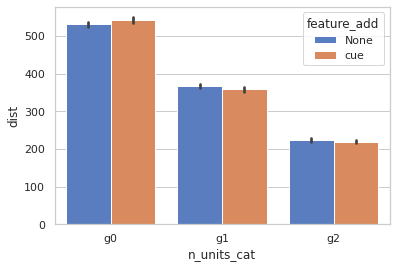

In [120]:
sns.barplot(data=tc, x='n_units_cat', y='dist', hue='feature_add')

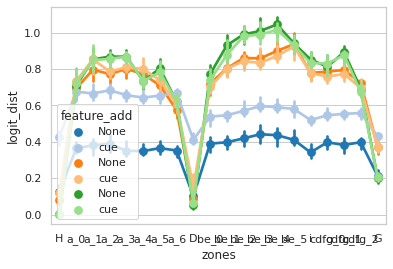

In [57]:
cols = sns.color_palette('tab20', n_colors=6)
cnt = 0
for g in unit_groups:
    sns.pointplot(data=tc[tc.n_units_cat==g],x='zones', y='logit_dist', hue='feature_add', palette=cols[cnt:cnt+2], estimator=np.median)
    cnt+=2

In [58]:
tc = t[(t.trial_type=='out') & (t.feature_add.isin(['None','cue']))].groupby(['session','subject','zones','n_units_cat', 'feature_add', 'fold'], observed=True).mean().reset_index()

vc_formula={'zones':'0+zones',
           'fold':'0+C(fold)'}
m =  smf.mixedlm('logit_dist~n_units_cat*feature_add', groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)
print(m.summary())
print(m.wald_test_terms())

m_null=smf.mixedlm('logit_dist~1+n_units_cat',groups='subject',re_formula='1',vc_formula=vc_formula, data=tc).fit(reml=False)

ps.LRT(m,m_null)

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        logit_dist 
No. Observations:         22698          Method:                    ML         
No. Groups:               5              Scale:                     1.3453     
Min. group size:          2600           Log-Likelihood:            -35735.7382
Max. group size:          6400           Converged:                 Yes        
Mean group size:          4539.6                                               
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             0.485    0.110  4.427 0.000  0.270  0.700
n_units_cat[T.g1]                     0.495    0.030 16.674 0.000  0.437  0.553
n_units_cat[T.g2]                     0.483    0.030 15.984 0

(44.168102523020934, 1.3900535439678808e-09)

## decision decoder

In [9]:
ei = reload(ei)
info = ei.SummaryInfo()

In [10]:
t = info.get_zone_decoder_dec_rw(True)

In [11]:
%%time
t['zones'] = t['zones'].astype(cat_type)
t['post_dec'] = t['zones']>'D'
unit_groups = [f'g{i}' for i in range(3)]
t['n_units_cat'] = pd.qcut(t.n_units,3, labels=[f'g{i}' for i in range(3)])

CPU times: user 8.18 ms, sys: 3.98 ms, total: 12.2 ms
Wall time: 10.8 ms


In [12]:
t

,target_type,zones,feature_add,trial_type,fold,acc,bac,dist,logit_dist,ldn,pr_target,correct,cue_match,subject,session,task,n_units,post_dec,n_units_cat
0,dec,H,None,out,0,0.461538,0.412500,0.538462,0.009638,-7.692308e-02,0.499375,0.846154,0.307692,Li,Li_T3g_052818,T3g,2,False,g0
1,dec,H,None,out,1,0.416667,0.416667,0.583333,0.011607,-1.666667e-01,0.499604,0.583333,0.500000,Li,Li_T3g_052818,T3g,2,False,g0
2,dec,H,None,out,2,0.500000,0.500000,0.500000,0.004101,1.528870e-13,0.500376,0.583333,0.416667,Li,Li_T3g_052818,T3g,2,False,g0
3,dec,H,None,out,3,0.454545,0.416667,0.545455,0.017227,-9.090909e-02,0.499656,0.818182,0.636364,Li,Li_T3g_052818,T3g,2,False,g0
4,dec,H,None,out,4,0.545455,0.687500,0.454545,0.021206,9.090909e-02,0.499218,0.818182,0.545455,Li,Li_T3g_052818,T3g,2,False,g0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24635,rw,G,None,in,0,0.285714,0.400000,0.714286,0.841160,-4.285714e-01,0.459996,0.714286,0.000000,Ca,Ca_T3g_042319,T3g,1,True,g0
24636,rw,G,None,in,1,0.666667,0.566667,0.333333,0.142015,3.333333e-01,0.564803,0.714286,0.000000,Ca,Ca_T3g_042319,T3g,1,True,g0
24637,rw,G,None,in,2,0.200000,0.238095,0.800000,0.539307,-6.000000e-01,0.438104,0.700000,0.000000,Ca,Ca_T3g_042319,T3g,1,True,g0
24638,rw,G,None,in,3,0.500000,0.547619,0.500000,0.166152,1.175171e-14,0.523590,0.700000,0.000000,Ca,Ca_T3g_042319,T3g,1,True,g0


<AxesSubplot:xlabel='zones', ylabel='cue_match'>

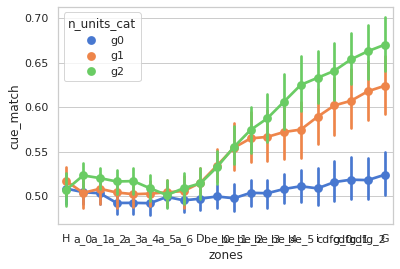

In [13]:
t1 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'zones', 'n_units_cat', ],observed=True).mean().reset_index()
sns.pointplot(data=t1, x='zones', y='cue_match', hue='n_units_cat')

<AxesSubplot:xlabel='zones', ylabel='val'>

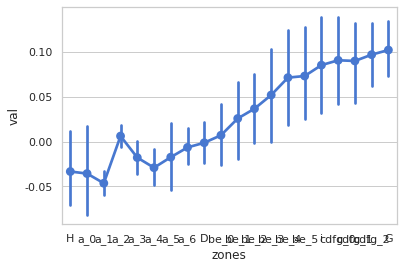

In [11]:
zones = tmf.TreeMazeZones().zones2
t1 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'subject', 'zones', 'n_units_cat','fold']).mean().reset_index().dropna()

d = pd.DataFrame(columns=['zones', 'fold', 'val'])
cnt = 0
for f in range(5):
    for z in zones:
        idx = (t1.zones==z) & (t1.fold==f) & (t1.n_units_cat>='g0')
        x = t1.loc[idx, 'acc']
        y = t1.loc[idx, 'correct']
        r = rs.kendall(x,y)

        d.loc[cnt, 'zones'] = z
        d.loc[cnt, 'val'] = r
        d.loc[cnt, 'fold']=f
        cnt +=1
sns.pointplot(x='zones', y='val', data=d)


In [166]:
t1 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'subject', 'zones', 'n_units_cat','fold']).mean().reset_index().dropna()
t1['zones'] = t1['zones'].astype(cat_type)
t1['post_dec'] = t1['zones']>'D'

vc_formula={'zones':'0+zones',
            #'units':'0+n_units',
           'fold':'0+C(fold)'}
m =  smf.mixedlm('bac~n_units_cat*post_dec', groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)
print(m.summary())
print(m.wald_test_terms())

m_null=smf.mixedlm('bac~1+n_units_cat+post_dec',groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)

print("LRT of units x bac")
print(ps.LRT(m,m_null))



                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        bac      
No. Observations:        11186          Method:                    ML       
No. Groups:              5              Scale:                     0.0177   
Min. group size:         1100           Log-Likelihood:            6549.2892
Max. group size:         3200           Converged:                 Yes      
Mean group size:         2237.2                                             
----------------------------------------------------------------------------
                                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.495    0.010 48.348 0.000  0.475  0.515
n_units_cat[T.g1]                  0.006    0.006  1.136 0.256 -0.005  0.017
n_units_cat[T.g2]                  0.011    0.006  1.871 0.061 -0.001  0.022
post_dec[T.True]   

In [209]:
t2 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'subject','zones','n_units_cat','fold']).mean().reset_index().dropna()
t2['zones'] = t2['zones'].astype(cat_type)
t2['post_dec'] = t2['zones']>'D'
t2 = t2.groupby(['session','n_units_cat', 'post_dec', 'fold'], observed=True).mean().reset_index()
t2

,session,n_units_cat,post_dec,fold,acc,bac,dist,logit_dist,ldn,pr_target,correct,n_units
0,AL_T3g_101218,g0,False,0,0.474747,0.468519,0.525253,0.006679,-0.050505,0.499531,0.636364,1.0
1,AL_T3g_101218,g0,False,1,0.439394,0.452778,0.560606,0.121918,-0.121212,0.495620,0.727273,1.0
2,AL_T3g_101218,g0,False,2,0.545455,0.478431,0.454545,0.024075,0.090909,0.499094,0.681818,1.0
3,AL_T3g_101218,g0,False,3,0.407407,0.393162,0.592593,0.099143,-0.185185,0.492918,0.761905,1.0
4,AL_T3g_101218,g0,False,4,0.380952,0.440972,0.619048,0.107622,-0.238095,0.491600,0.714286,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1115,Ne_T3i_060818,g0,True,0,0.757576,0.650000,0.242424,0.217230,0.515152,0.705501,0.600000,4.0
1116,Ne_T3i_060818,g0,True,1,0.818182,0.797727,0.181818,0.259312,0.636364,0.725384,0.785714,4.0
1117,Ne_T3i_060818,g0,True,2,0.766234,0.652273,0.233766,0.760239,0.532468,0.653651,0.785714,4.0
1118,Ne_T3i_060818,g0,True,3,0.482517,0.507576,0.517483,1.512272,-0.034965,0.553381,0.769231,4.0


In [214]:
d = pd.DataFrame(columns=['session', 'post_dec', 'n_units_cat','t','p'])
cnt = 0
for s in t2.session.unique():
    for p in [False,True]:
        x = t2[(t2.session==s) & (t2.post_dec==p)].bac
        tp = scipy.stats.ttest_1samp(x,0.5)
        d.loc[cnt,'t'] = tp[0]
        d.loc[cnt,'p'] = tp[1]
        d.loc[cnt, 'session'] = s
        d.loc[cnt, 'post_dec'] = p
        cnt+=1
d['n_units_cat'] = d.session.map(lambda x: t2.loc[t2.session==x, 'n_units_cat'].values[0])

In [197]:
d

,session,post_dec,n_units_cat,t,p


In [223]:
for g in unit_groups:
    idx = (d.post_dec==False) & (d.n_units_cat==g)
    ns = (d.loc[idx,'t']>0).sum()
    print(g, ns, idx.sum(), ns/idx.sum())

g0 19 42 0.4523809523809524
g1 18 34 0.5294117647058824
g2 23 36 0.6388888888888888


In [221]:
for g in unit_groups:
    idx = (d.post_dec==True) & (d.n_units_cat==g)
    ns = (d.loc[idx,'t']>0).sum()
    print(g, ns/idx.sum())

g0 0.6190476190476191
g1 0.9117647058823529
g2 0.9444444444444444


In [189]:
(d.loc[d.post_dec==True,'p']<0.05).sum()

58

In [35]:
t1 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'subject', 'zones', 'n_units_cat','fold']).mean().reset_index().dropna()
t1['zones'] = t1['zones'].astype(cat_type)
t1['post_dec'] = t1['zones']>'D'

vc_formula={'zones':'0+zones',
            #'units':'0+n_units',
           'fold':'0+C(fold)'}
m =  smf.mixedlm('correct~cue_match*n_units_cat+cue_match*post_dec', groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)
print(m.summary())
print(m.wald_test_terms())

m_null=smf.mixedlm('correct~1+n_units_cat+cue_match*post_dec',groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)

print("LRT of units x bac")
print(ps.LRT(m,m_null))

m_null2=smf.mixedlm('correct~1+n_units_cat*cue_match+post_dec',groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)

print("LRT of post_Dec x bac")
print(ps.LRT(m,m_null2))

m_null3 = m
m =  smf.mixedlm('correct~cue_match*n_units_cat*post_dec', groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)
print("LRT of units x bac x post_dec")
print(ps.LRT(m,m_null3))

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      correct  
No. Observations:      11186        Method:                  ML       
No. Groups:            5            Scale:                   0.0177   
Min. group size:       1100         Log-Likelihood:          6609.8683
Max. group size:       3200         Converged:               Yes      
Mean group size:       2237.2                                         
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.788    0.062 12.738 0.000  0.667  0.909
n_units_cat[T.g1]           -0.079    0.014 -5.564 0.000 -0.107 -0.051
n_units_cat[T.g2]           -0.116    0.014 -8.065 0.000 -0.144 -0.088
post_dec[T.True]            -0.111    0.012 -9.293 0.000 -0.134 -0.088
cue_match              

In [40]:
m =  smf.mixedlm('correct~cue_match*n_units_cat*post_dec', groups='subject',re_formula='1',vc_formula=vc_formula, data=t1).fit(reml=False)
print(m.summary())
print(m.wald_test_terms())

                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           correct  
No. Observations:             11186             Method:                       ML       
No. Groups:                   5                 Scale:                        0.0176   
Min. group size:              1100              Log-Likelihood:               6642.8209
Max. group size:              3200              Converged:                    No       
Mean group size:              2237.2                                                   
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                     0.740    0.062 11.902 0.000  0.618  0.862
n_units_cat[T.g1]                            -0.015    0.

<AxesSubplot:xlabel='cue_match', ylabel='correct'>

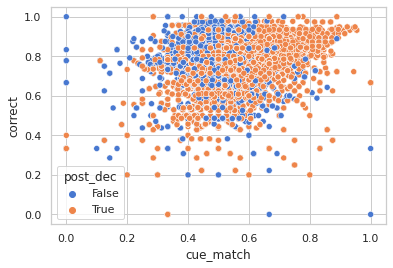

In [37]:
sns.scatterplot(data=t1, x='cue_match', y='correct', hue='post_dec')

In [21]:
t1 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'subject', 'zones', 'n_units_cat','fold']).mean().reset_index().dropna()

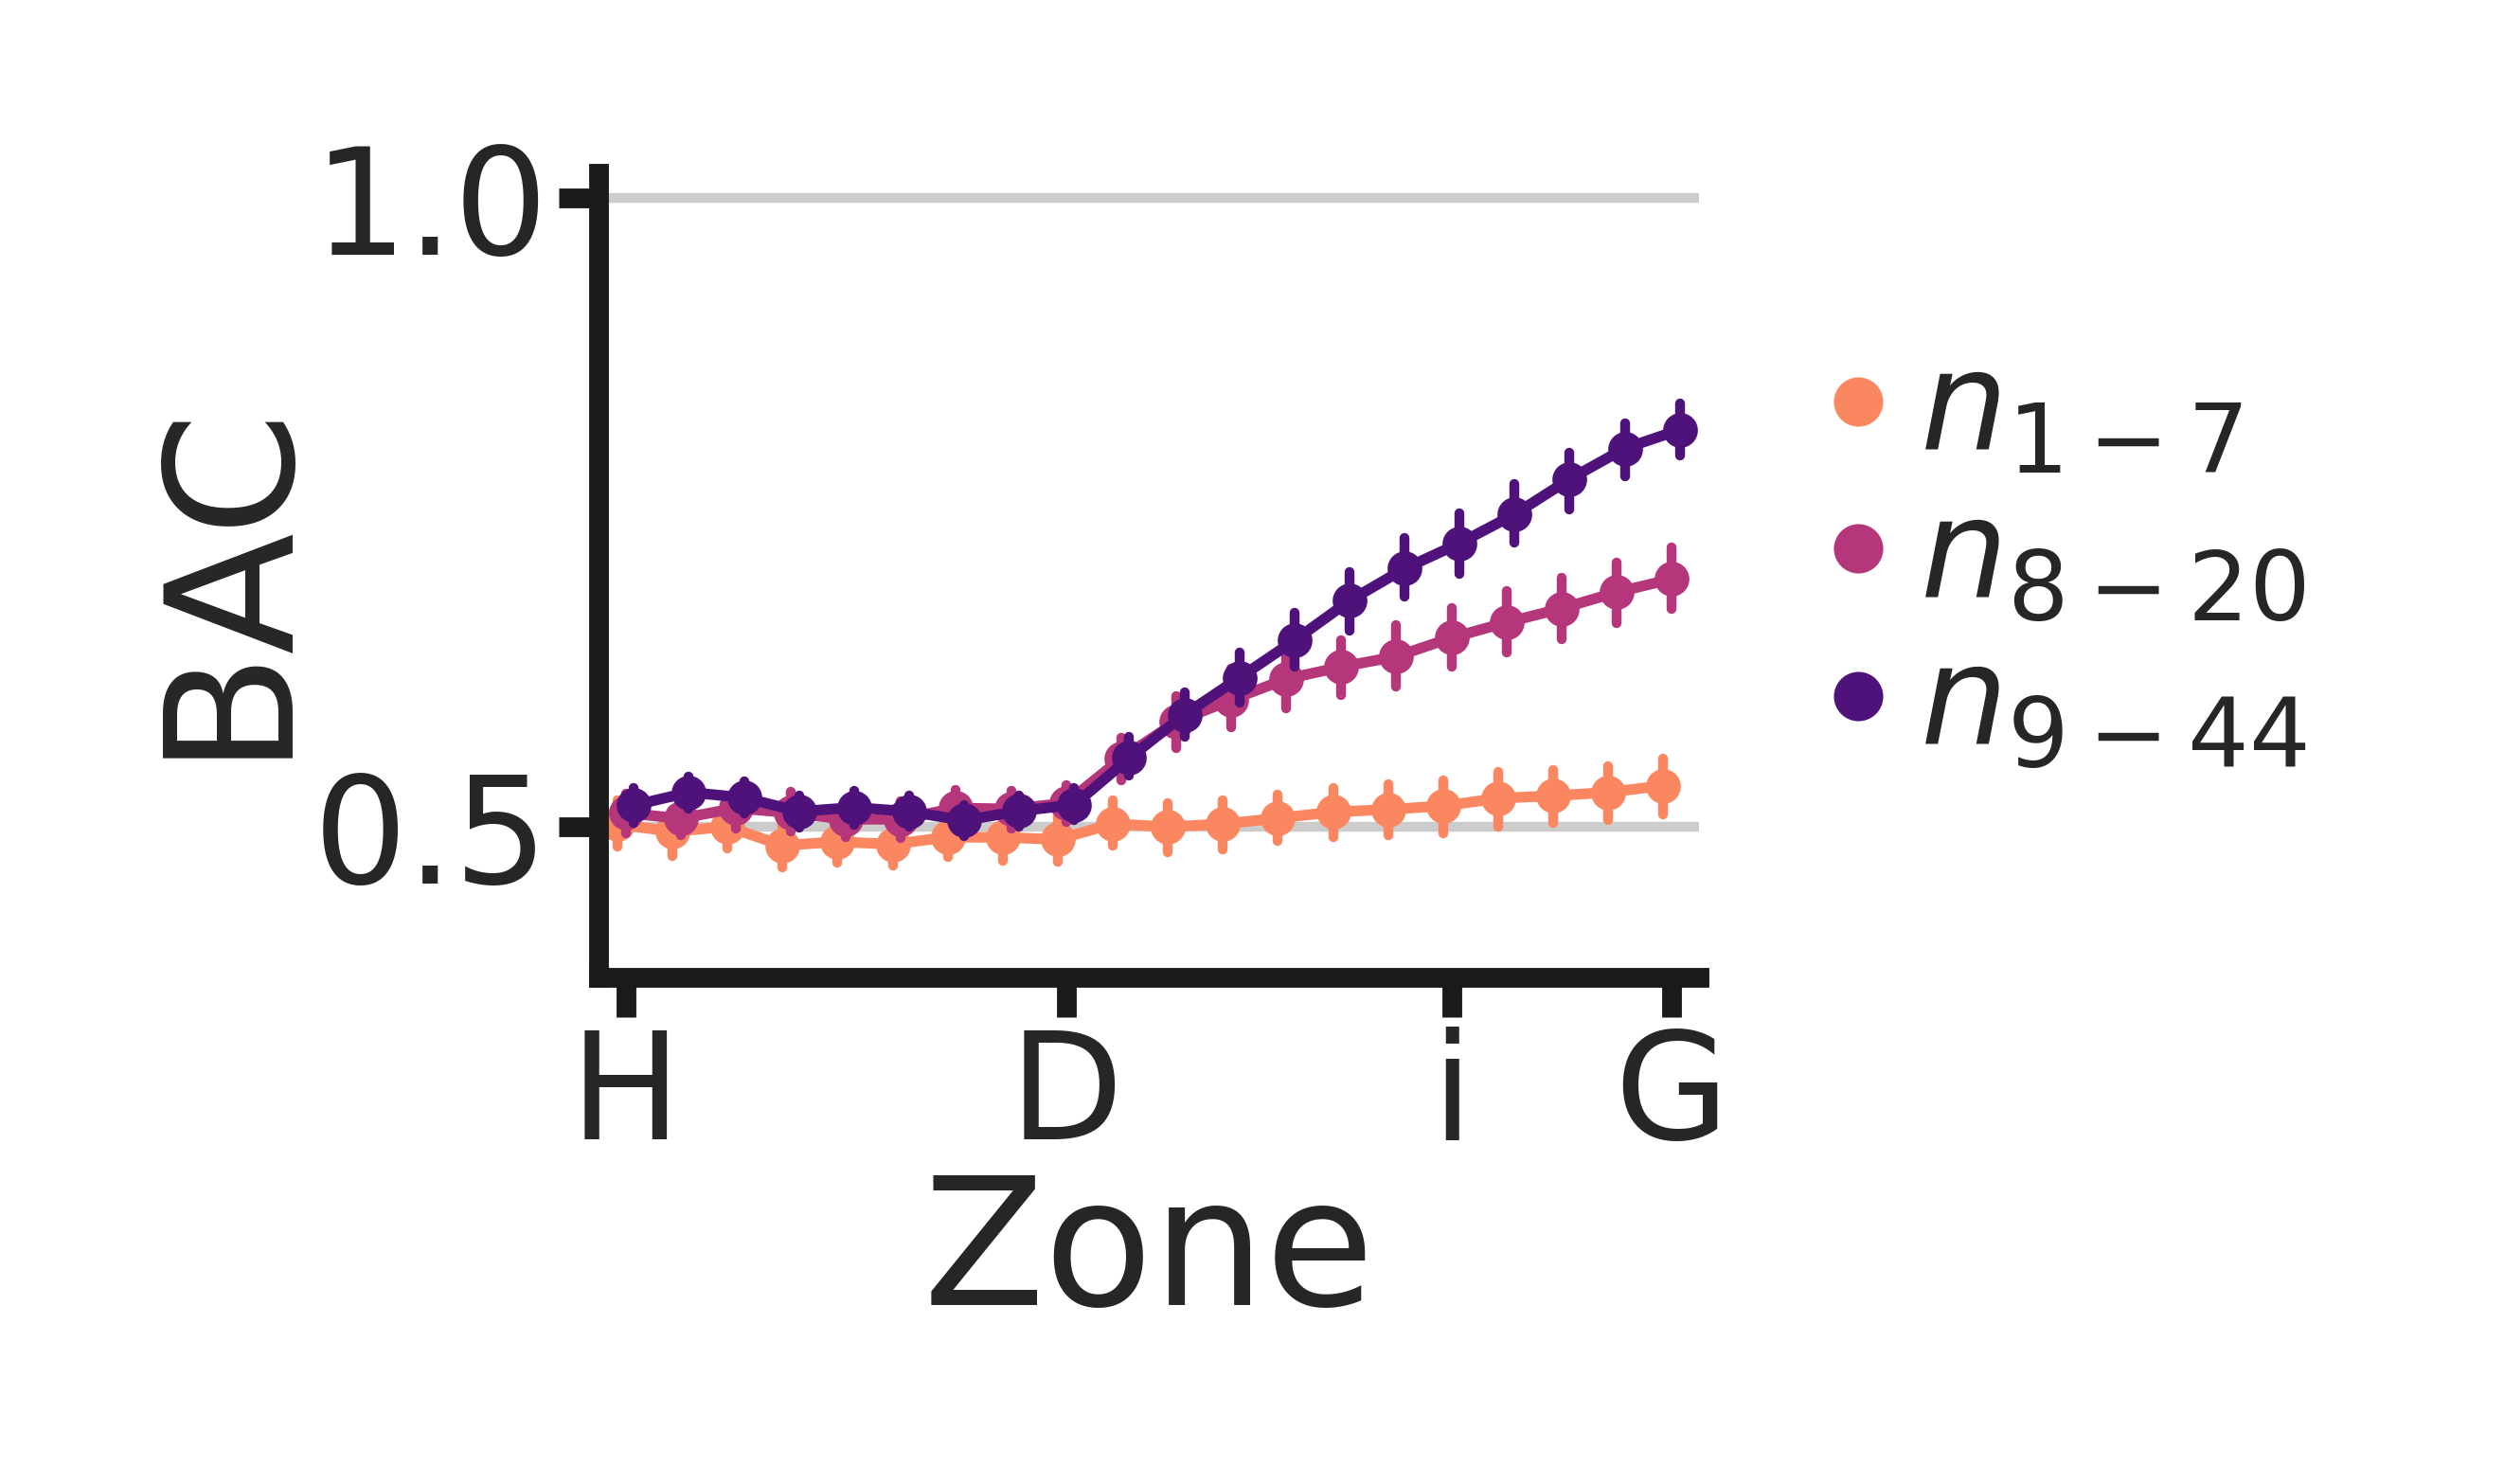

In [24]:
pf = reload(pf)
metric = 'bac'
dpi=1500
f, _ = pf.plot_decoder_out_v_zones(data=t1, metric=metric, hue='n_units_cat',  figsize=(1,0.75), **dict(hue_labels=[f'$n_{{1-7}}$', f'$n_{{8-20}}$',f'$n_{{9-44}}$'], ylim=[0.38, 1.02], ylabel=metric.upper(), point_scale=0.2, leg_marker_size=1.5))

fn = f"dec_decoder_{metric}_x_zone_unit.svg"
# f.savefig(fig_path/fn, format='svg', dpi=dpi, facecolor=None, pad_inches=0, bbox_inches='tight')

<AxesSubplot:xlabel='zones', ylabel='val'>

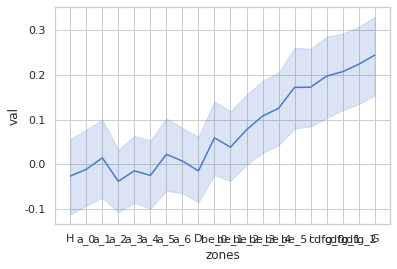

In [29]:
zones = tmf.TreeMazeZones().zones2
t1 = t[(t.target_type=='dec') & (t.trial_type=='out')].groupby(['session', 'subject', 'zones', 'n_units_cat','fold']).mean().reset_index().dropna()

d = pd.DataFrame(columns=['zones', 'session', 'val', 'n_units_cat'])
cnt = 0
for s in t1.session.unique():
    for z in zones:
        idx = (t1.zones==z) & (t1.session==s)
        try:
            x = t1.loc[idx, 'cue_match'].values
            y = t1.loc[idx, 'correct'].values
            r = rs.kendall(x,y)#(y-x).mean()

            d.loc[cnt, 'session']=s
            d.loc[cnt, 'zones'] = z
            d.loc[cnt,'n_units_cat']= t1.loc[t1.session==s,'n_units_cat'].iloc[0]
            d.loc[cnt, 'val'] = r
            cnt +=1
        except:
            pass
#sns.pointplot(x='zones', y='val', data=d)
sns.lineplot(x='zones', y='val', data=d)


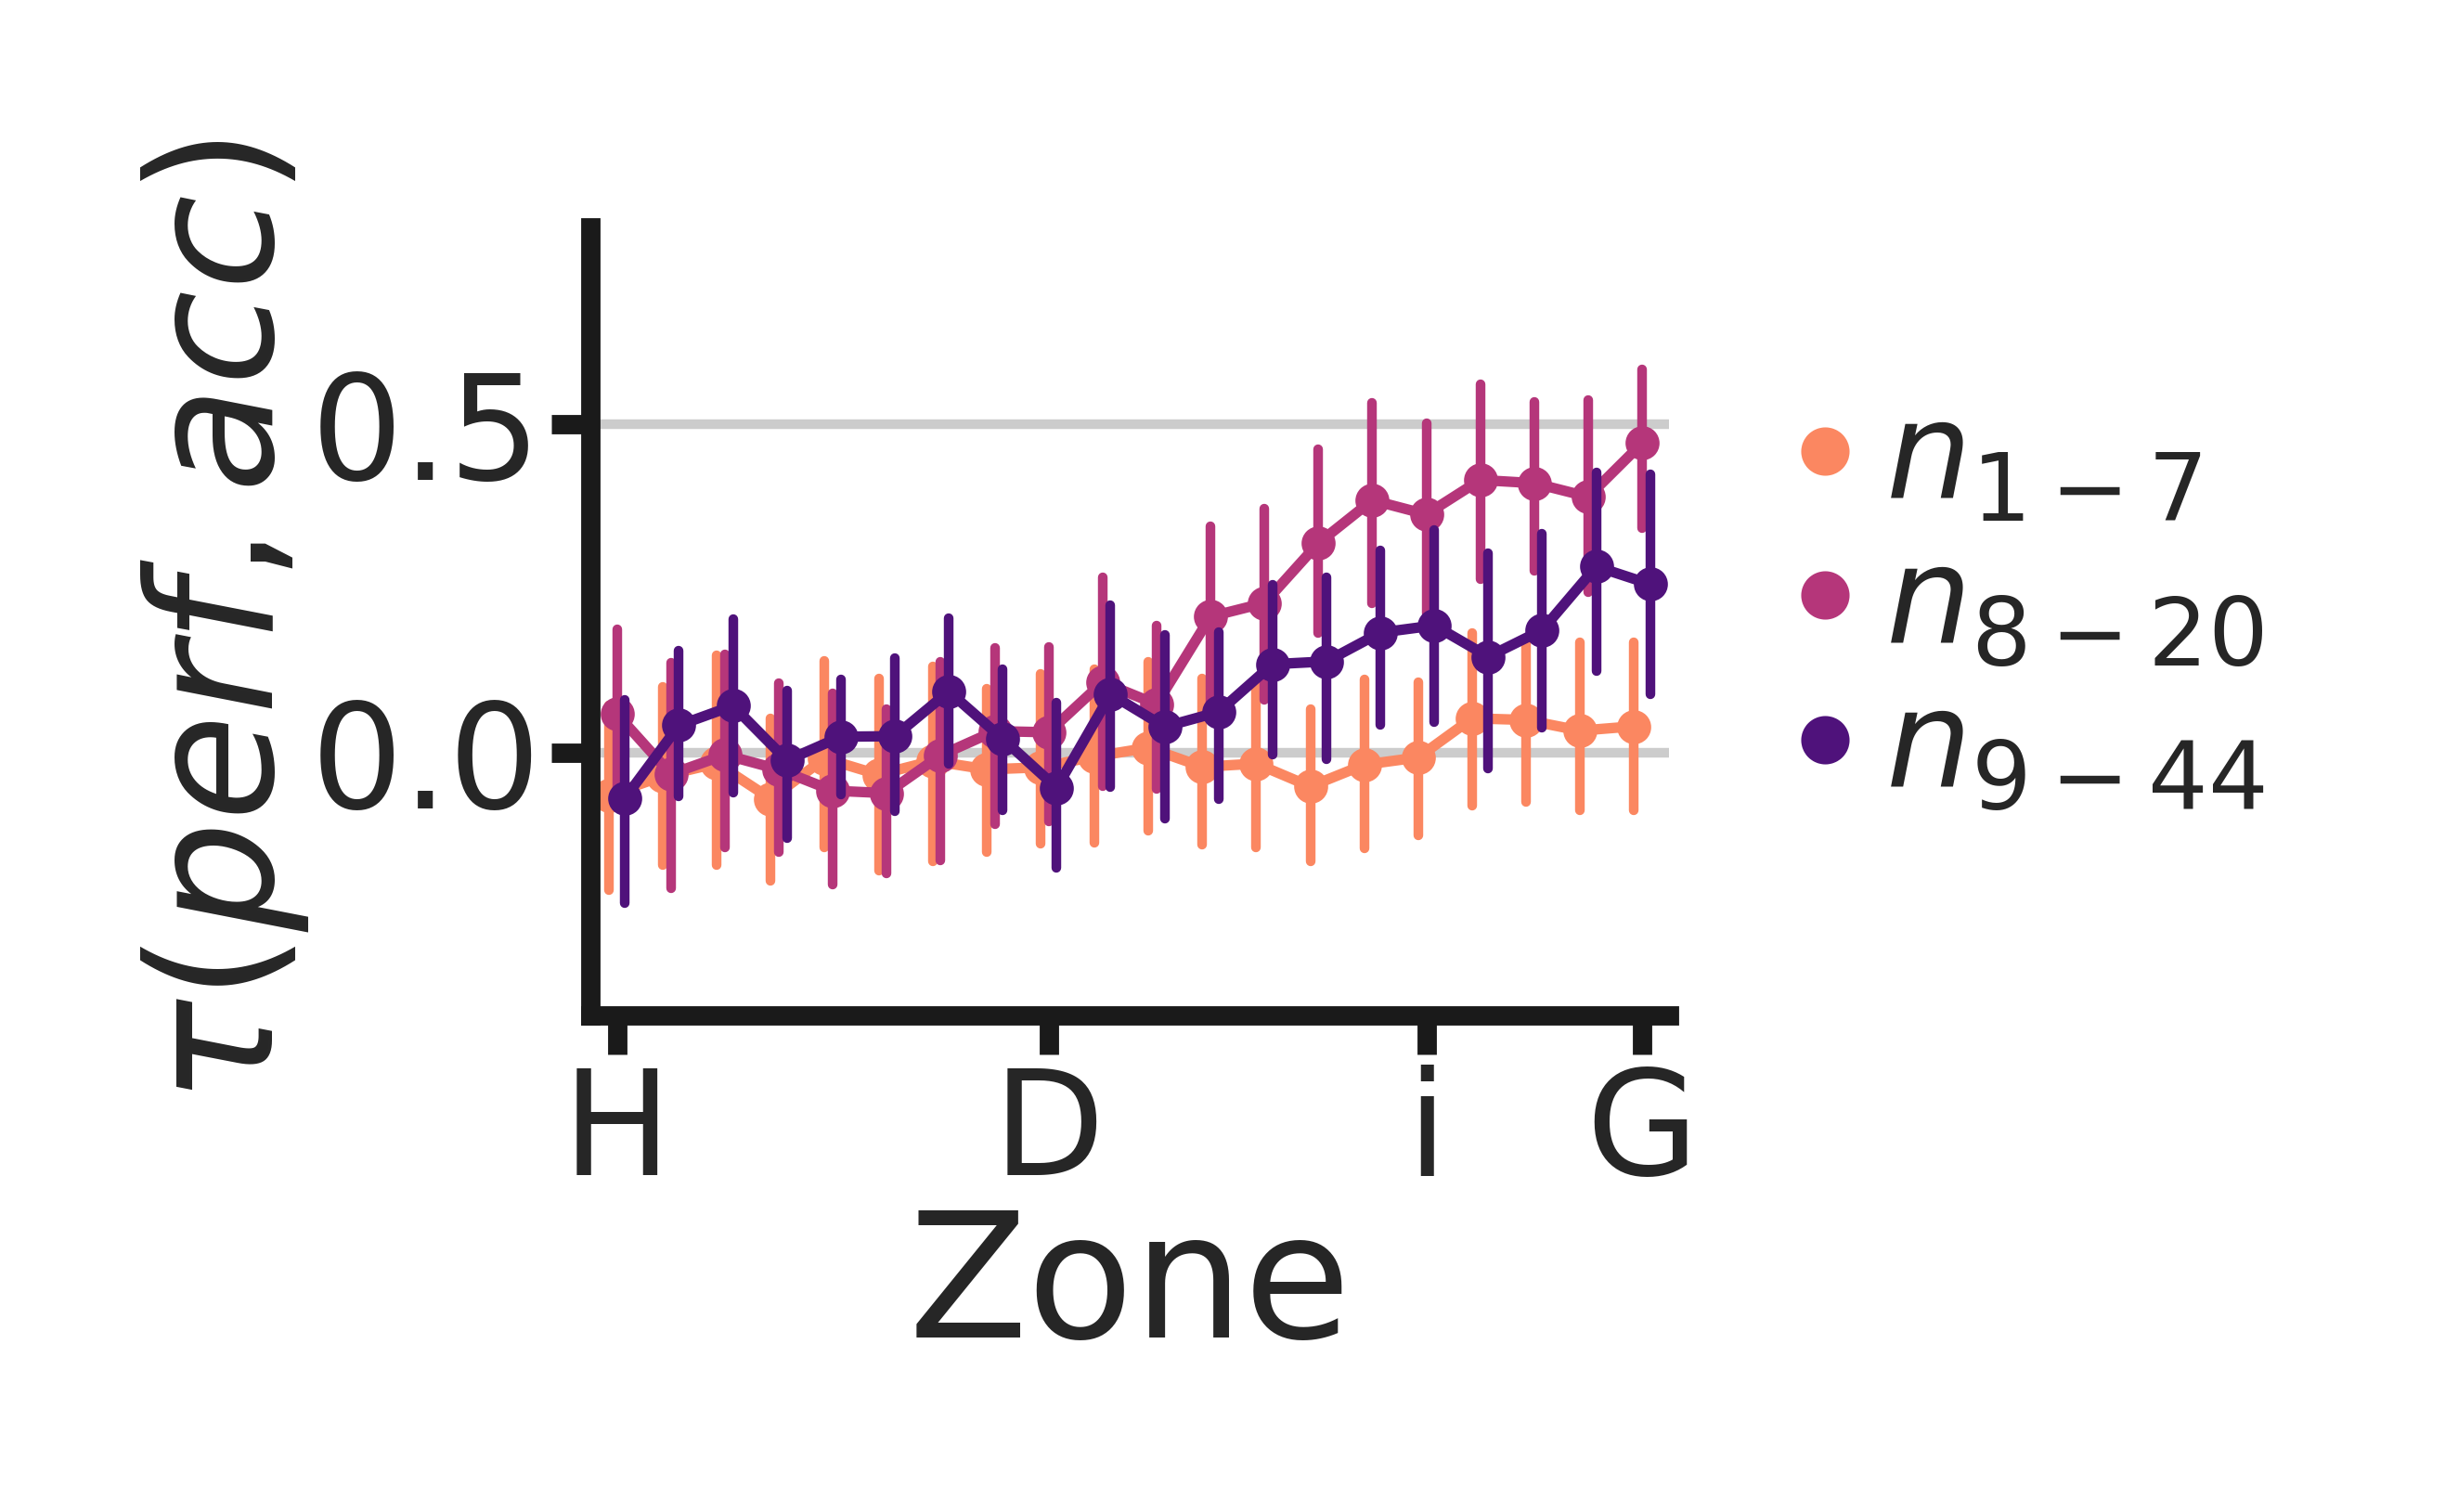

In [34]:
metric='corr_perf_cue_match'
metric_label = r"$\tau{(perf, acc)}$"
pf = reload(pf)
f, _ = pf.plot_decoder_out_v_zones(data=d.dropna(), metric='val', hue='n_units_cat',   figsize=(1,0.75), **dict(hue_labels=[f'$n_{{1-7}}$', f'$n_{{8-20}}$',f'$n_{{9-44}}$'], ylim=[-0.4, 0.8], ylabel=metric_label, point_scale=0.2, leg_marker_size=1.5))


fn = f"dec_decoder_{metric}_x_zone_unit.svg"
f.savefig(fig_path/fn, format='svg', dpi=dpi, facecolor=None, pad_inches=0, bbox_inches='tight')

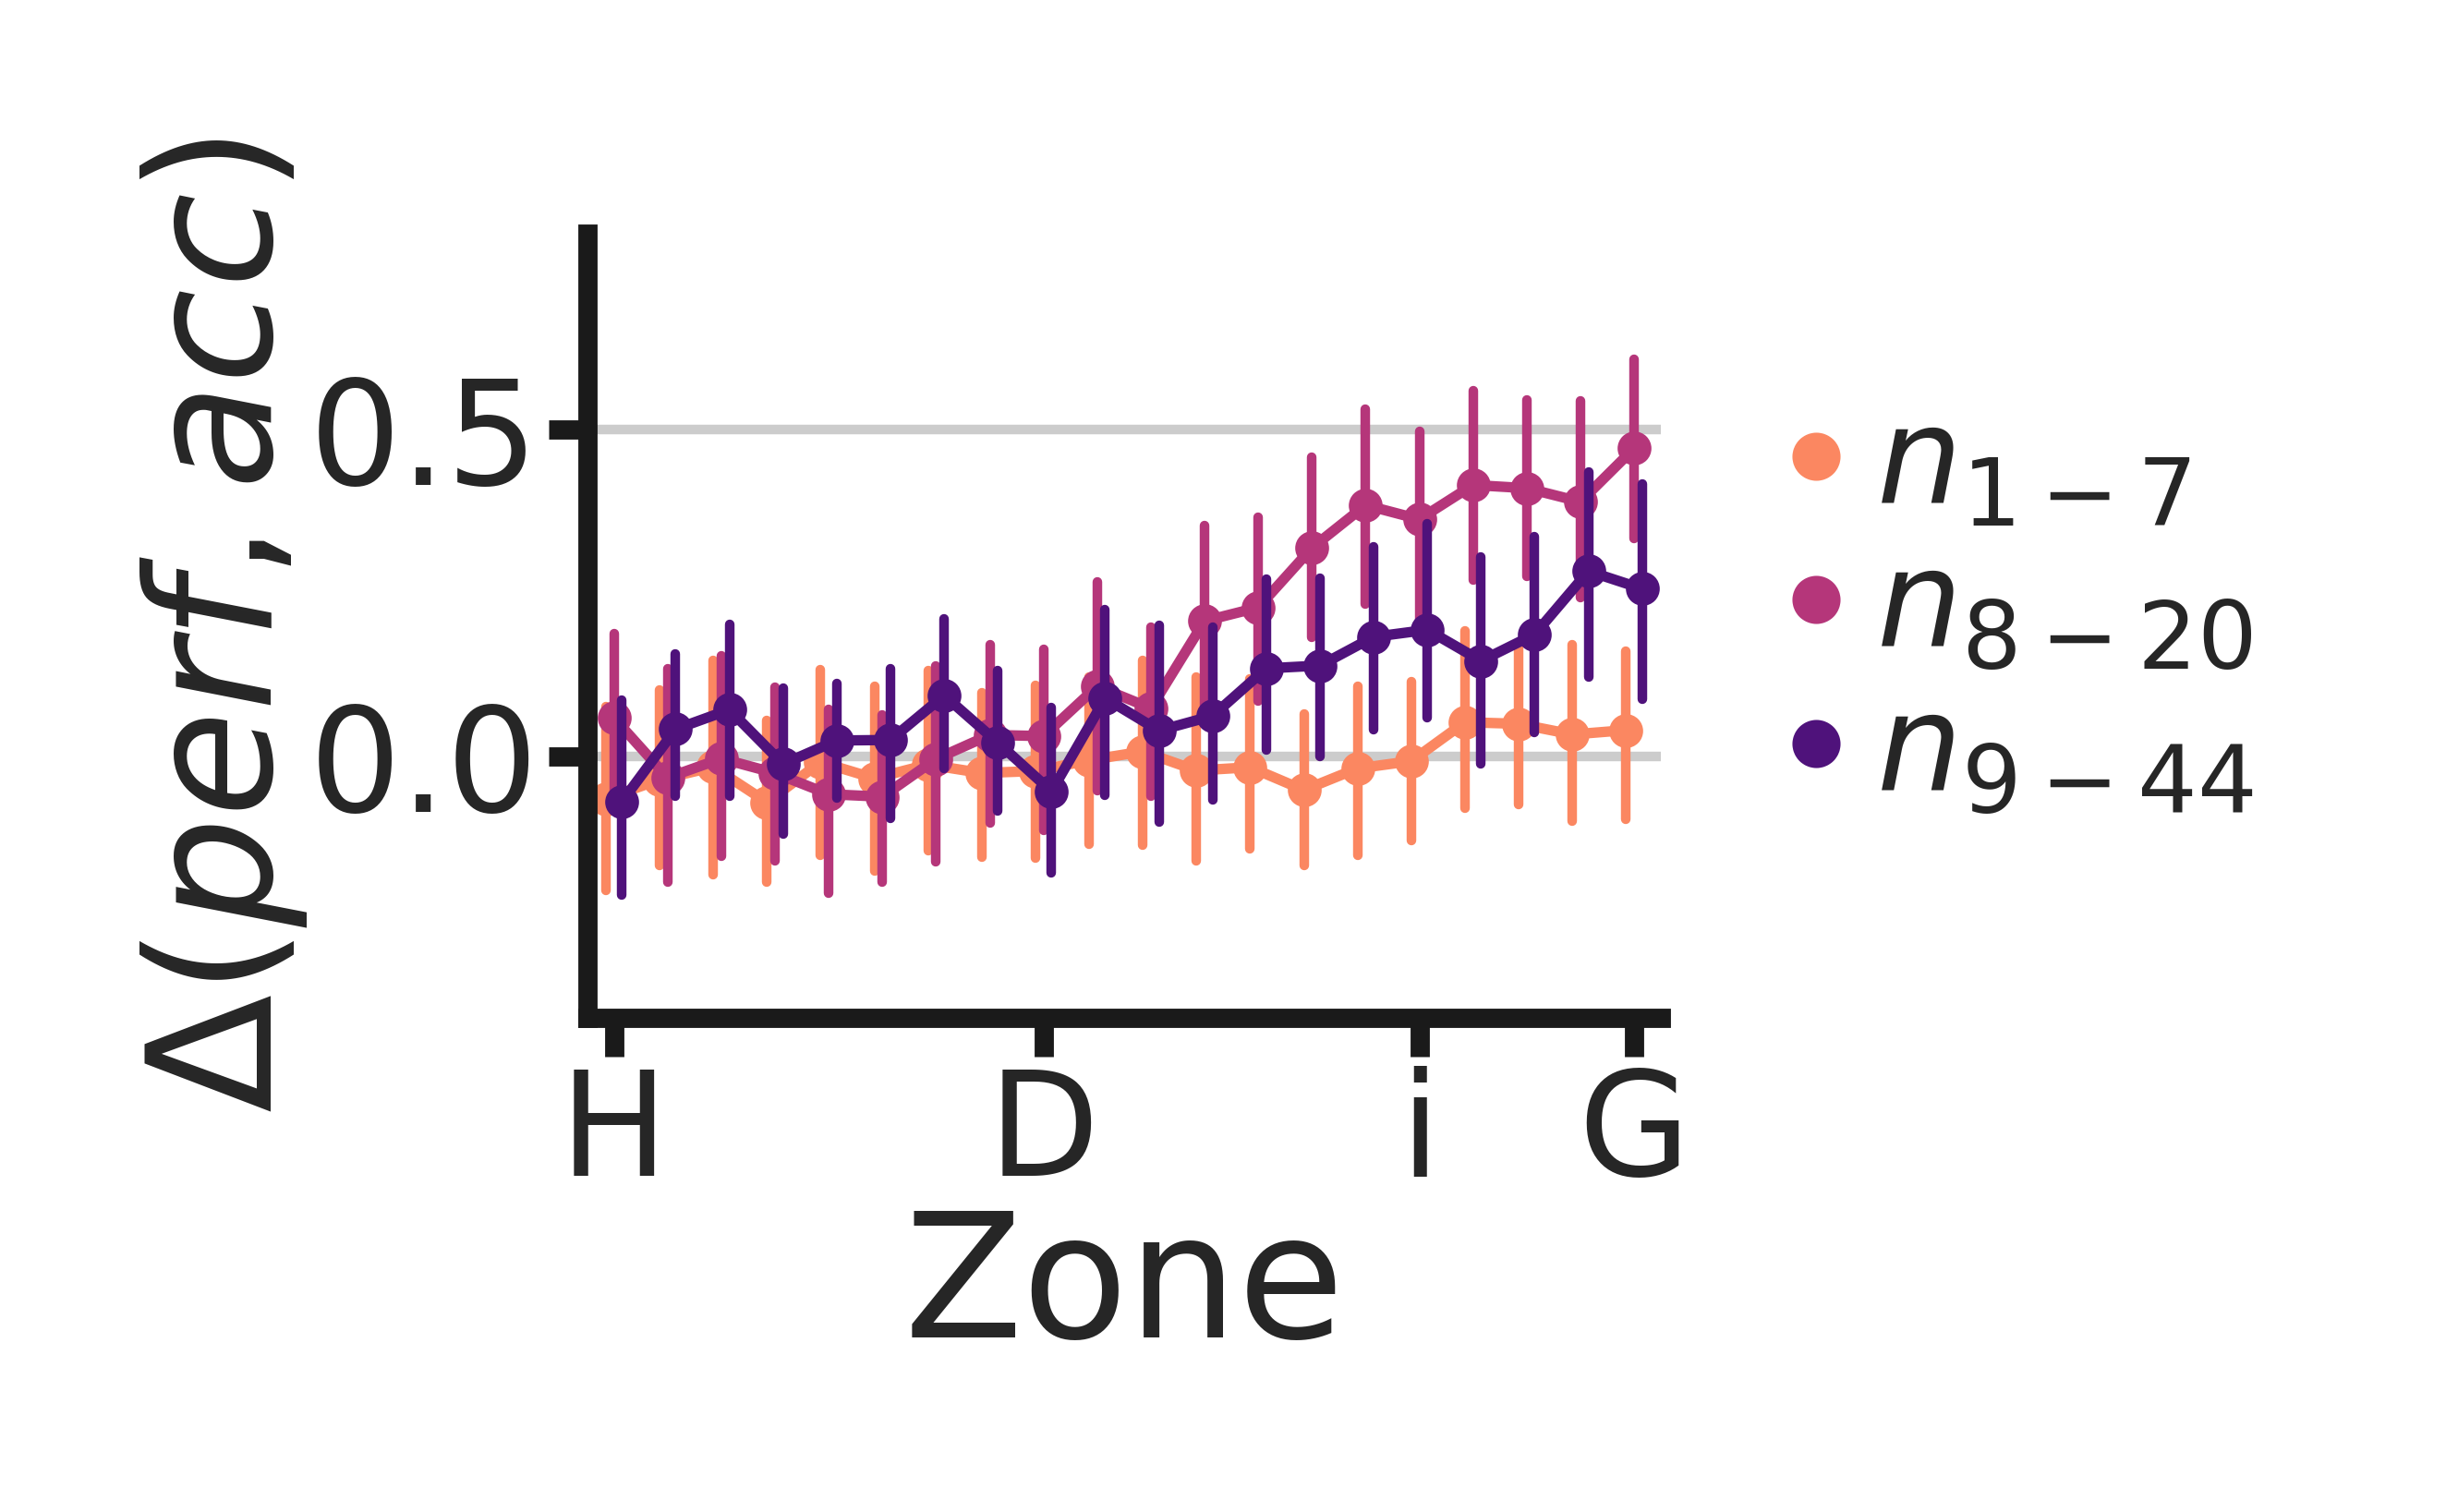

In [30]:
metric='delta_perf_acc'
metric_label = r"$\Delta{(perf,acc)}$"

pf = reload(pf)
f, _ = pf.plot_decoder_out_v_zones(data=d.dropna(), metric='val', hue='n_units_cat',   figsize=(1,0.75), **dict(hue_labels=[f'$n_{{1-7}}$', f'$n_{{8-20}}$',f'$n_{{9-44}}$'], ylim=[-0.4, 0.8], ylabel=metric_label, point_scale=0.2, leg_marker_size=1.5))


fn = f"dec_decoder_{metric}_x_zone_unit.svg"
# f.savefig(fig_path/fn, format='svg', dpi=dpi, facecolor=None, pad_inches=0, bbox_inches='tight')

<AxesSubplot:xlabel='zones', ylabel='bac'>

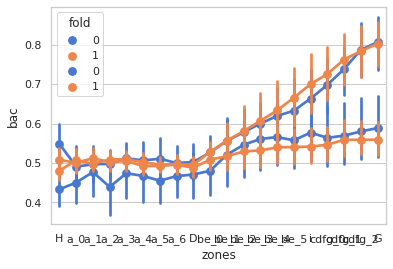

In [123]:
t2 = t[(t.target_type=='dec') & (t.trial_type=='out_co')].groupby(['session', 'subject', 'zones', 'n_units_cat', 'fold']).mean().reset_index()
sns.pointplot(data=t2[t2.n_units_cat=='g0'], x='zones', y='bac', hue='fold')
sns.pointplot(data=t2[t2.n_units_cat=='g2'], x='zones', y='bac', hue='fold')

<AxesSubplot:xlabel='zones', ylabel='val'>

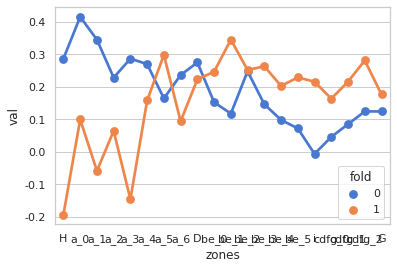

In [115]:
zones = tmf.TreeMazeZones().zones2
groups = ['g0','g1', 'g2']
d = pd.DataFrame(columns=['fold', 'zones', 'val'])
cnt = 0
for z in zones:
    for g in groups:
        for f in [0,1]:
            idx = (t2.fold==f) & (t2.zones==z)  & (t1.n_units_cat>='g0')
            x = t2.loc[idx, 'bac']
            y = t2.loc[idx, 'pct_correct']
            r = rs.kendall(x,y)
            
            d.loc[cnt, 'fold'] = f
            d.loc[cnt, 'zones'] = z
            d.loc[cnt, 'val'] = r
            cnt +=1
sns.pointplot(x='zones', y='val', data=d, hue='fold')

In [134]:
t2 = t[(t.target_type=='dec') & (t.trial_type=='out_co')].groupby(['session', 'subject', 'zones', 'n_units_cat', 'fold']).mean().reset_index().dropna()

vc_formula={'zones':'0+zones',
            'units':'0+n_units'}
smf.mixedlm('pct_correct~bac+n_error_trials', groups='subject',re_formula='1',vc_formula=vc_formula, data=t2[t2.fold==0]).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM Dependent Variable: pct_correct
No. Observations:  1020    Method:             REML       
No. Groups:        5       Scale:              0.0033     
Min. group size:   40      Log-Likelihood:     1424.0231  
Max. group size:   380     Converged:          Yes        
Mean group size:   204.0                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       0.840    0.040  21.252 0.000  0.763  0.918
bac             0.069    0.011   6.436 0.000  0.048  0.090
n_error_trials -0.004    0.000 -32.965 0.000 -0.004 -0.004
subject Var     0.007    0.089                            
units Var       0.001    0.021                            
zones Var       0.000                                     
==========================================================

"""

<AxesSubplot:xlabel='zones', ylabel='val'>

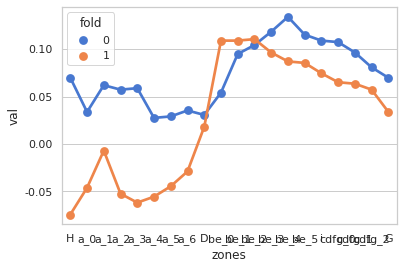

In [27]:
t = info.get_zone_decoder_cue()
t['n_units_cat'] = pd.qcut(t.n_units,3)
b = info.get_behav_perf()


## decoder figs

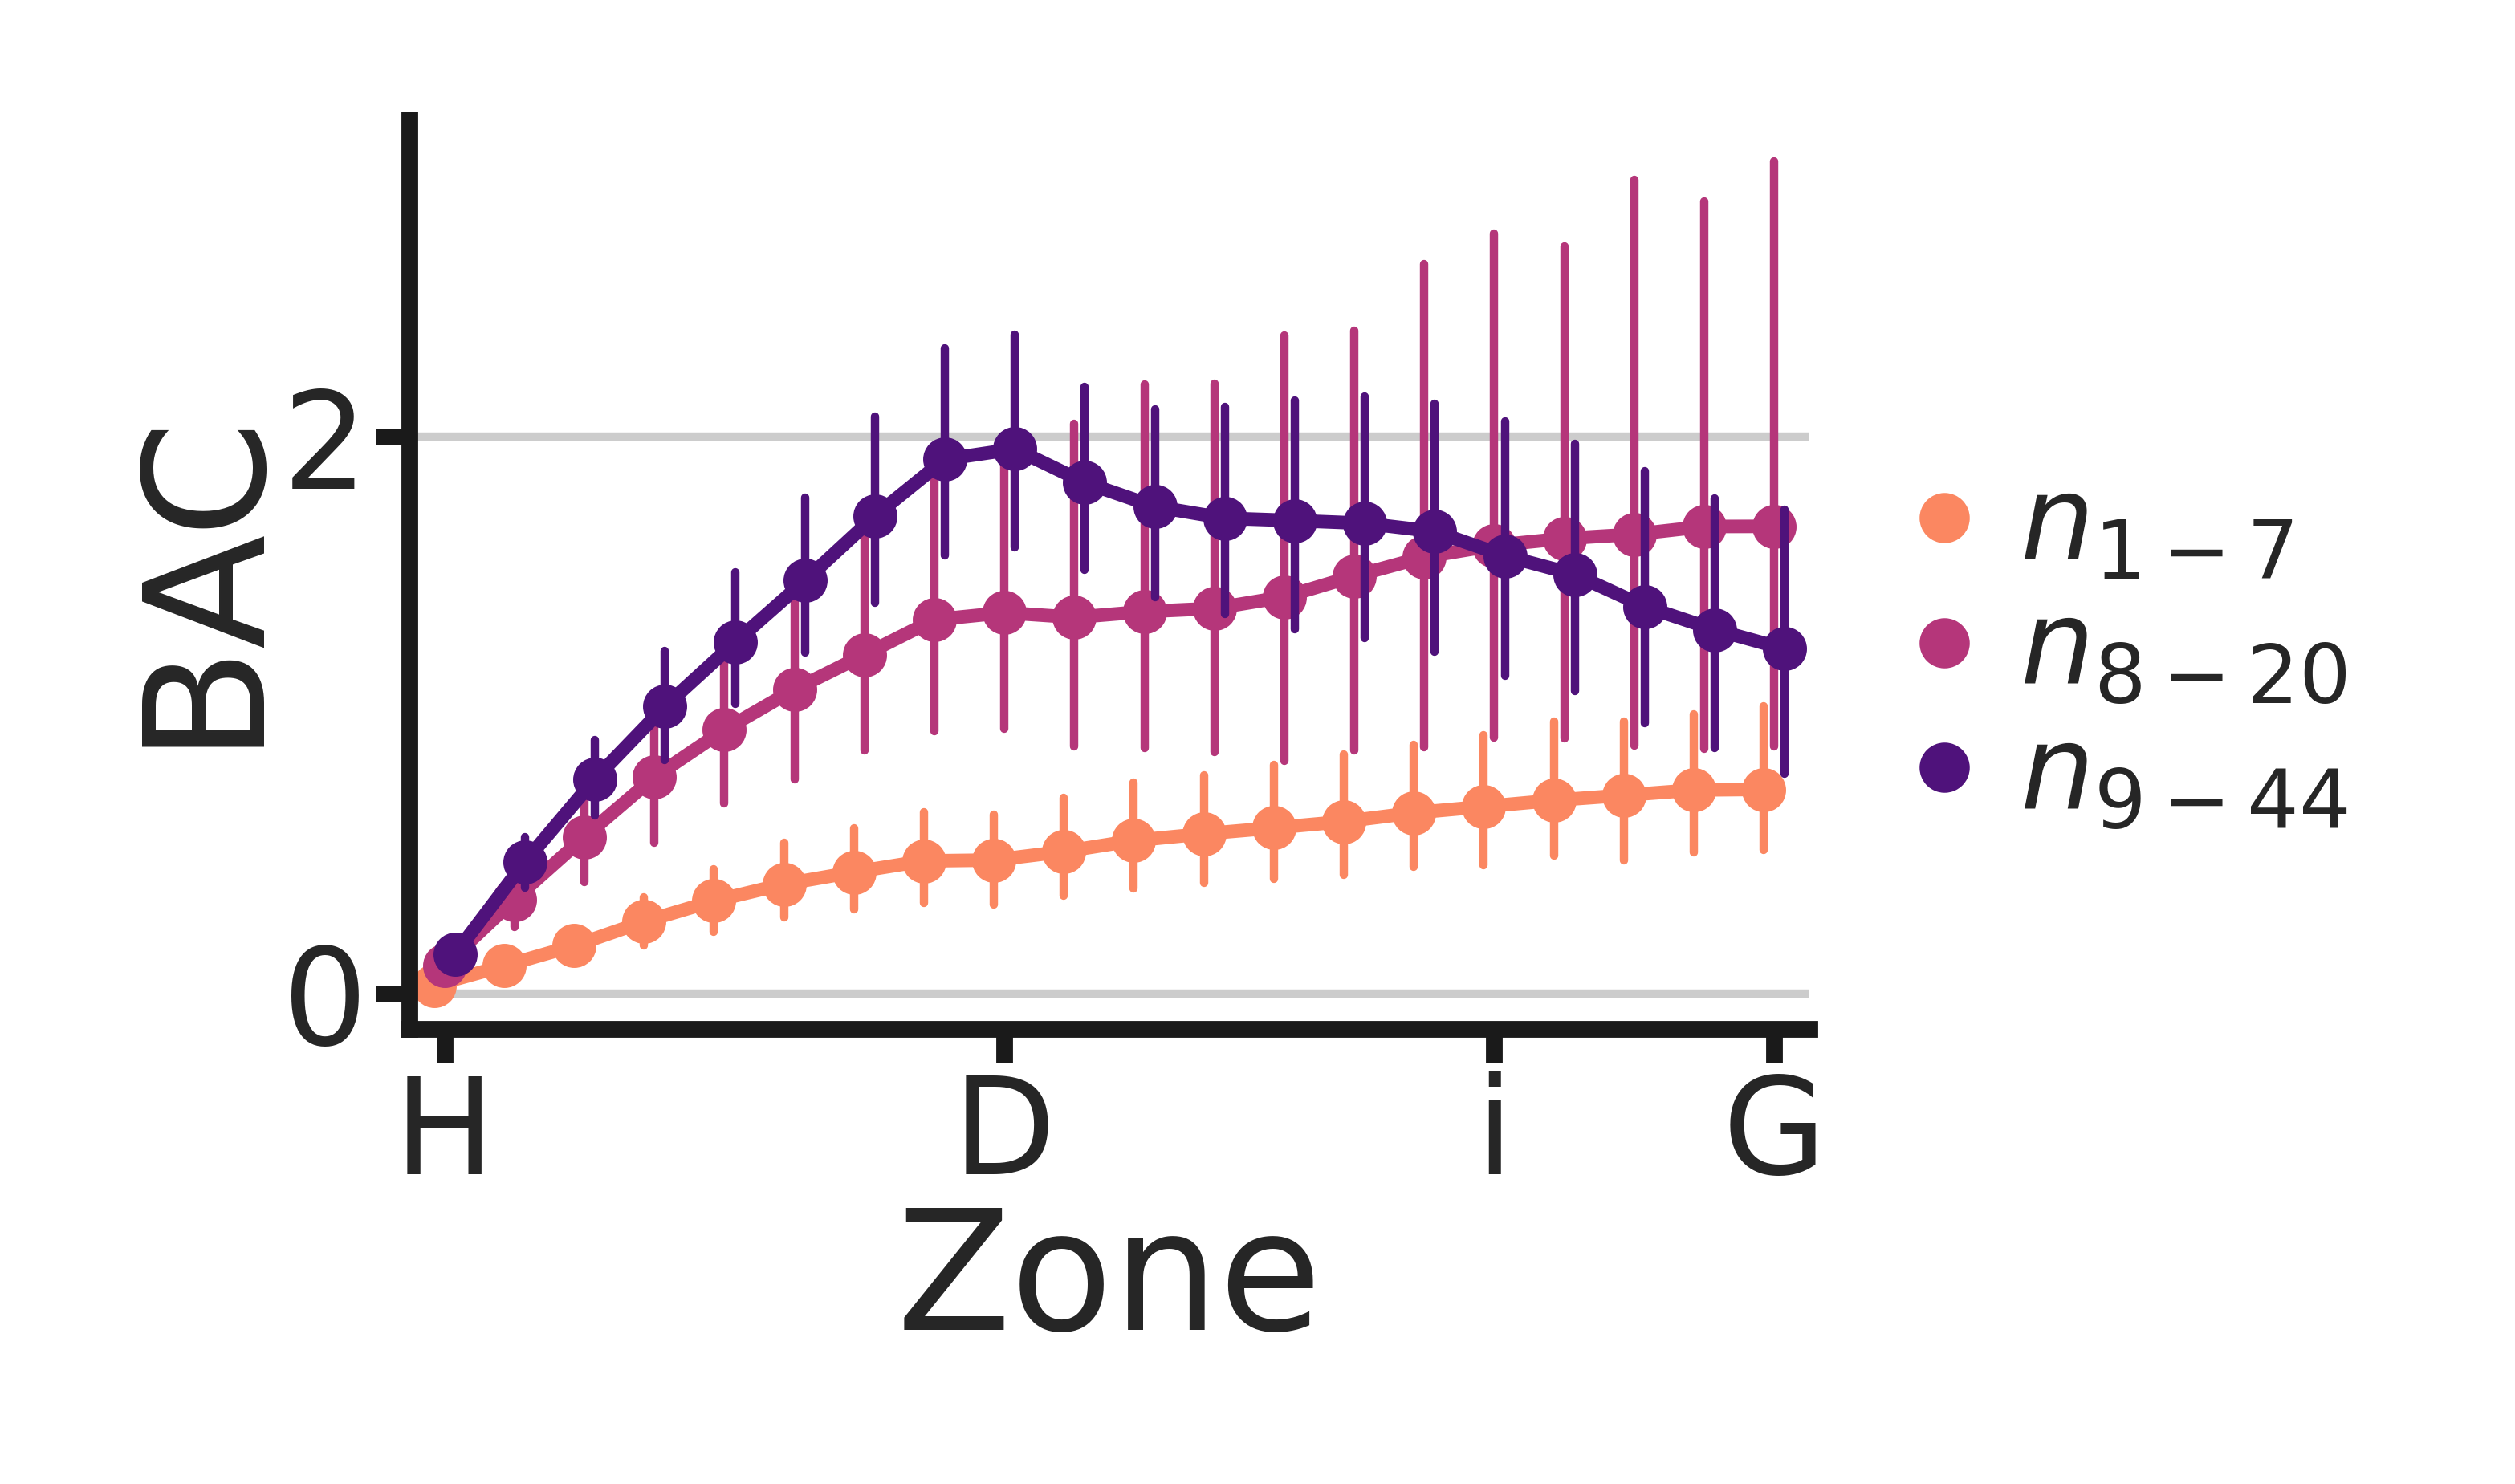

In [41]:
dpi=1500
fontsize = 10
tick_fontsize=8
legend_fontsize=7

mpl.rcParams['axes.unicode_minus'] = False


min_err_trials = 10
sessions = b.session[(b.n_trials*(1-b.pct_correct)>=min_err_trials)].values
 
t2 = t[(t.target_type=='dec') & (t.session.isin(sessions))]

metric = 'logit_dist'
palette_name = 'magma_r'
leg_marker_size=2
palette = sns.color_palette(palette_name, n_colors=3)
unit_splits = [f'$n_{{1-7}}$', f'$n_{{8-20}}$',f'$n_{{9-44}}$' ]

fn = f"decoder_dec_perf_incorrects_{metric}_unit_split.svg"

f,ax=plt.subplots(figsize=(1.5,1), dpi=dpi)

pf.setup_axes(ax, fontsize=tick_fontsize)

sns.pointplot(data=t2, x='zones', y=metric, hue='n_units_cat', palette=palette_name, dodge=0.3, ax=ax, scale=0.3, errwidth=0.5)

# sns.lineplot(data=de_cue, x='zones', y='bac', hue=hue, hue_order=name_map.keys(), palette=palette, markers=False, ax=ax)
ax.get_legend().remove()
ax.set_xticks([0,8,15,19])
#ax.set_ylim([0.38,1.02])
#ax.axhline(0.5, linestyle='--', color='0.3', zorder=-1, lw=0.7)

ax.set_xlabel('Zone', fontsize=fontsize, labelpad=0)
ax.set_ylabel('BAC', fontsize=fontsize,  labelpad=0)

leg_pos = [1, 0.1]

legend_elements = []
for ii, k in enumerate(unit_splits):
    legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=k, markerfacecolor=palette[ii], markersize=leg_marker_size))
    
ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=leg_pos, frameon=False,
             fontsize=legend_fontsize, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

# sns.despine(ax=ax)
# ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

# for sp in ['bottom', 'left']:
#     ax.spines[sp].set_linewidth(1)
#     ax.spines[sp].set_color('0.2')

# ax.grid(linewidth=0.5)


# f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [46]:
sns.pointplot(x='logit_dist', y='bac', hue='zones', data=t2)

KeyboardInterrupt: 

,n_trials,n_sw_trials,n_vsw_trials,n_L_trials,n_R_trials,pct_correct,pct_sw_correct,pct_vsw_correct,pct_L_correct,pct_R_correct,session,task,subject,n_units,n_cells,n_mua
0,61,28,21,27,34,0.716667,0.750000,0.809524,0.666667,0.735294,Li_T3g_052818,T3g,Li,2,0,2
1,179,64,52,86,93,0.848315,0.843750,0.865385,0.825581,0.860215,Li_T3g_052918,T3g,Li,14,6,8
2,146,58,43,64,82,0.786207,0.844828,0.813953,0.625000,0.902439,Li_T3g_053018,T3g,Li,9,5,4
3,161,77,65,78,83,0.800000,0.844156,0.861538,0.692308,0.891566,Li_T3g_053118,T3g,Li,16,5,11
4,176,65,52,85,91,0.833333,0.861538,0.942308,0.788235,0.857143,Li_T3g_060118,T3g,Li,14,5,9


1      Li_T3g_052918
2      Li_T3g_053018
3      Li_T3g_053118
4      Li_T3g_060118
5      Li_T3g_060418
           ...      
163    Ca_T3g_041119
164    Ca_T3g_041619
165    Ca_T3g_041919
166    Ca_T3g_042219
167    Ca_T3g_042319
Name: session, Length: 134, dtype: object